In [1]:
#load library
library(broom)
library(tidyverse)
library(dplyr)
library(lubridate)
library(grid)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.1
✔ readr   2.1.2     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




**Data Coloumn Interpretation**


No: row number

year: year of data in this row

month: month of data in this row

day: day of data in this row

hour: hour of data in this row

pm2.5: $PM2.5$ concentration $(ug/m^3)$ 

DEWP: Dew Point $(°C)$

TEMP: Temperature $(°C)$

PRES: Pressure $(hPa)$

cbwd: Combined wind direction

Iws: Cumulated wind speed $(m/s)$

Is: Cumulated hours of snow

Ir: Cumulated hours of rain

In [2]:
# loading data
pm2.5 <- read.csv("~/project.csv", header=TRUE)
pm2.5 <- as_tibble(pm2.5)
head(pm2.5)

No year month day hour pm2.5 DEWP TEMP PRES cbwd Iws   Is Ir
1 1  2010 1     1   0    NA    -21  -11  1021 NW    1.79 0  0 
2 2  2010 1     1   1    NA    -21  -12  1020 NW    4.92 0  0 
3 3  2010 1     1   2    NA    -21  -11  1019 NW    6.71 0  0 
4 4  2010 1     1   3    NA    -21  -14  1019 NW    9.84 0  0 
5 5  2010 1     1   4    NA    -20  -12  1018 NW   12.97 0  0 
6 6  2010 1     1   5    NA    -19  -10  1017 NW   16.10 0  0

**Removing 24 hours data for one day if one hour missing**

From the original data, we can see that the data set is counted by hour, so there should be $24$ data per day, but some data are not measured at certain points in time because of observation, so in order to facilitate the statistical value of $pm2.5$ by day, so if there is a missing value in a day, then we delete the $pm2.5$ data of all moments of that day.

In [3]:
#remove the all the moments of a day with at least one hour missing data
#remove the line with missing data
pm2.5_n<- na.omit(pm2.5)
#number of data witout na
nrow(pm2.5_n)

pm2.5_tidy<- pm2.5_n%>%add_count(year,month,day)%>%
  filter(n==24)
# number of remined data
nrow(pm2.5_tidy)

# view the dataframe to make sure it is processed properly
head(pm2.5_tidy)
idx_pos <- pm2.5_tidy$pm2.5>0
pm2.5_tidy <- pm2.5_tidy[idx_pos,]
pm2.5_tidy$pm2.5 <- log(pm2.5_tidy$pm2.5)

[1] 41757

[1] 37704

No year month day hour pm2.5 DEWP TEMP PRES cbwd Iws  Is Ir n 
1 25 2010 1     2   0    129   -16  -4   1020 SE   1.79 0  0  24
2 26 2010 1     2   1    148   -15  -4   1020 SE   2.68 0  0  24
3 27 2010 1     2   2    159   -11  -5   1021 SE   3.57 0  0  24
4 28 2010 1     2   3    181    -7  -5   1022 SE   5.36 1  0  24
5 29 2010 1     2   4    138    -7  -5   1022 SE   6.25 2  0  24
6 30 2010 1     2   5    109    -7  -6   1022 SE   7.14 3  0  24

In [4]:
sum(pm2.5_tidy$pm2.5<30)

[1] 37702

In [5]:
#Summarize the data, counting how many occurences of each year
pm2.5_tidy%>%
  group_by(year)%>%
  summarize(count=n())

year count
1 2010 7680 
2 2011 6912 
3 2012 7198 
4 2013 7920 
5 2014 7992

To further explore the **seasonal characteristics** of pm2.5 index, we need to divide the original data into seasons, where March, April and May are classified as **spring**, June, July and August are classified as **summer**, September, October and November are classified as **autumn**, and December, January and February are classified as **winter**. 

No year month day hour pm2.5    DEWP TEMP PRES cbwd Iws  Is Ir n  season
1 25 2010 1     2   0    4.859812 -16  -4   1020 SE   1.79 0  0  24 Winter
2 26 2010 1     2   1    4.997212 -15  -4   1020 SE   2.68 0  0  24 Winter
3 27 2010 1     2   2    5.068904 -11  -5   1021 SE   3.57 0  0  24 Winter
4 28 2010 1     2   3    5.198497  -7  -5   1022 SE   5.36 1  0  24 Winter
5 29 2010 1     2   4    4.927254  -7  -5   1022 SE   6.25 2  0  24 Winter
6 30 2010 1     2   5    4.691348  -7  -6   1022 SE   7.14 3  0  24 Winter

season n   
1 Fall   9550
2 Spring 9312
3 Summer 9072
4 Winter 9768

Warning message:
“`fun.y` is deprecated. Use `fun` instead.”


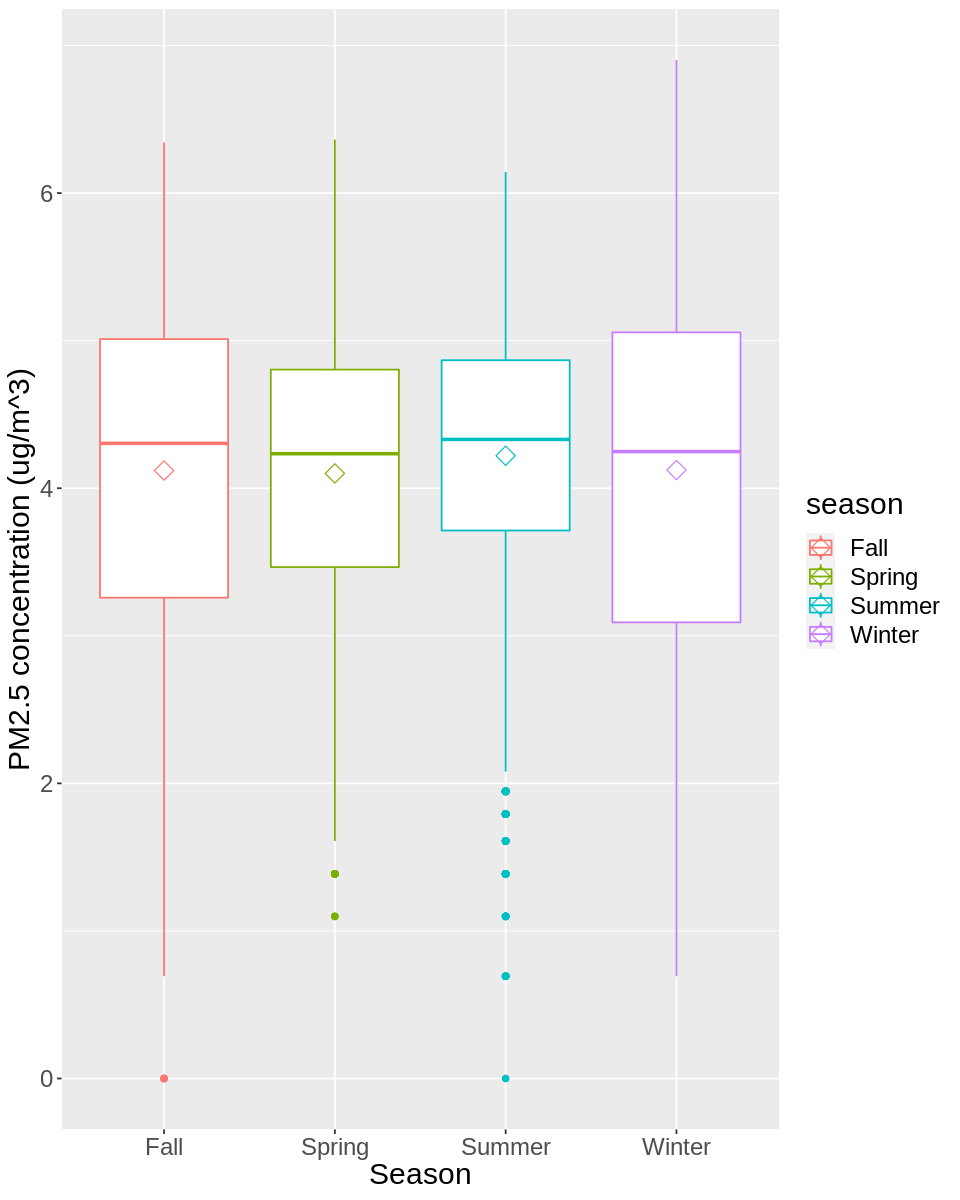

In [6]:
#classify with season
pm2.5_s <- pm2.5_tidy %>%
  mutate(
    season = case_when(
      month %in% 9:11 ~ "Fall",
      month %in%  3:5  ~ "Spring",
      month %in%  6:8  ~ "Summer",
      TRUE ~ "Winter"))
pm2.5_s$season <- as.factor(pm2.5_s$season)
pm2.5_s$cbwd <- as.factor(pm2.5_s$cbwd)
head(pm2.5_s)
#season check
season_check<-pm2.5_s%>% group_by(season)%>% summarize(n=n())
season_check
#use box plot to explore the seasonal characteristics of pm2.5 index 
options(repr.plot.width = 8, repr.plot.height = 10)
season_p<-ggplot(pm2.5_s, aes(x=season, y=pm2.5, color=season)) +
  geom_boxplot() +
  xlab("Season") +
  ylab("PM2.5 concentration (ug/m^3)") +
  theme(text = element_text(size = 18))+
  # Box plot with mean points
  stat_summary(fun.y=mean, geom="point", shape=23, size=4)

season_p

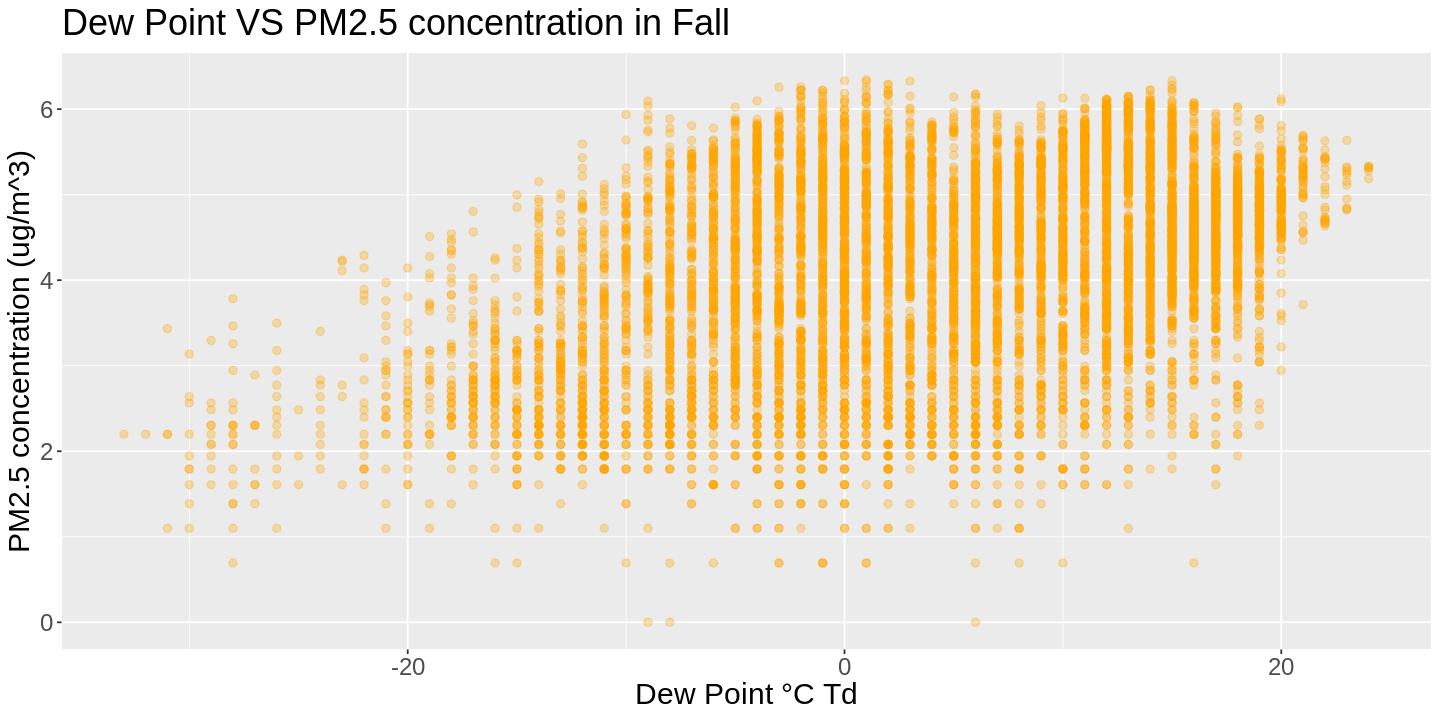

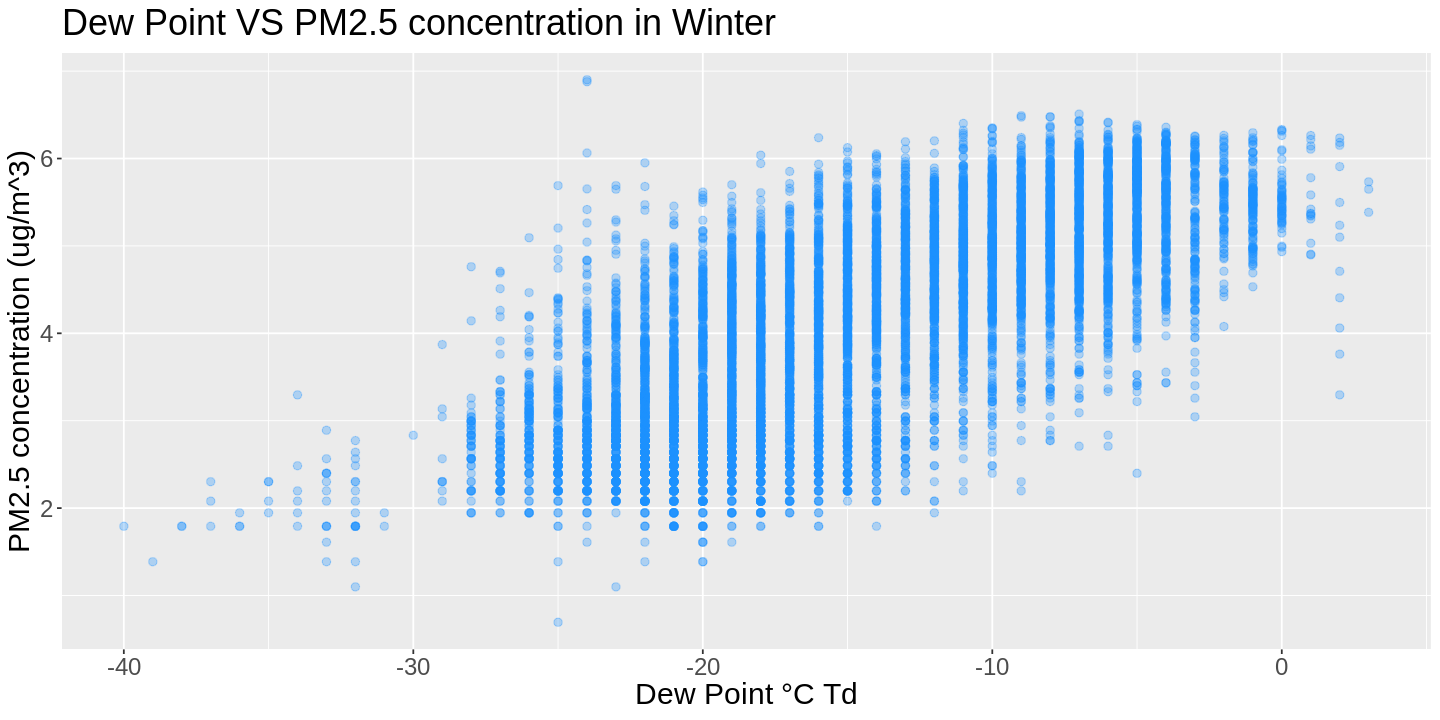

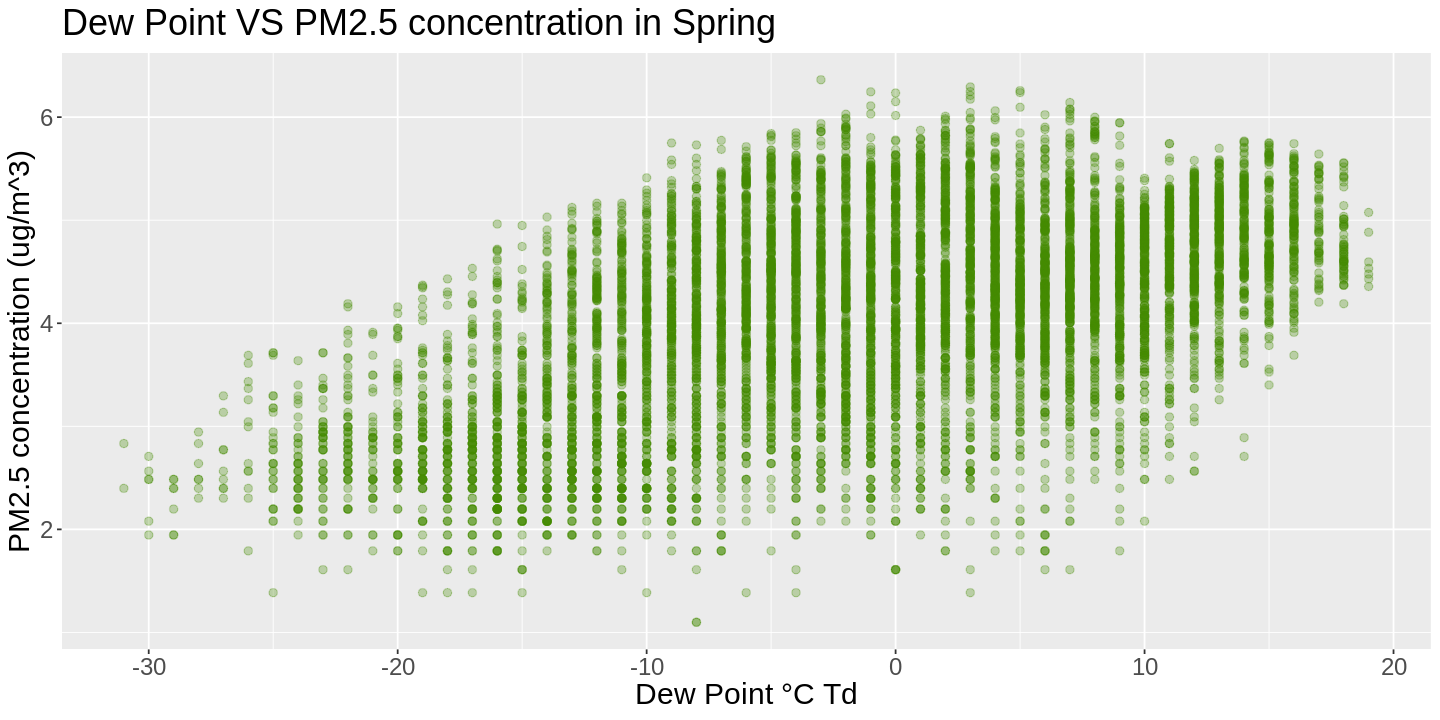

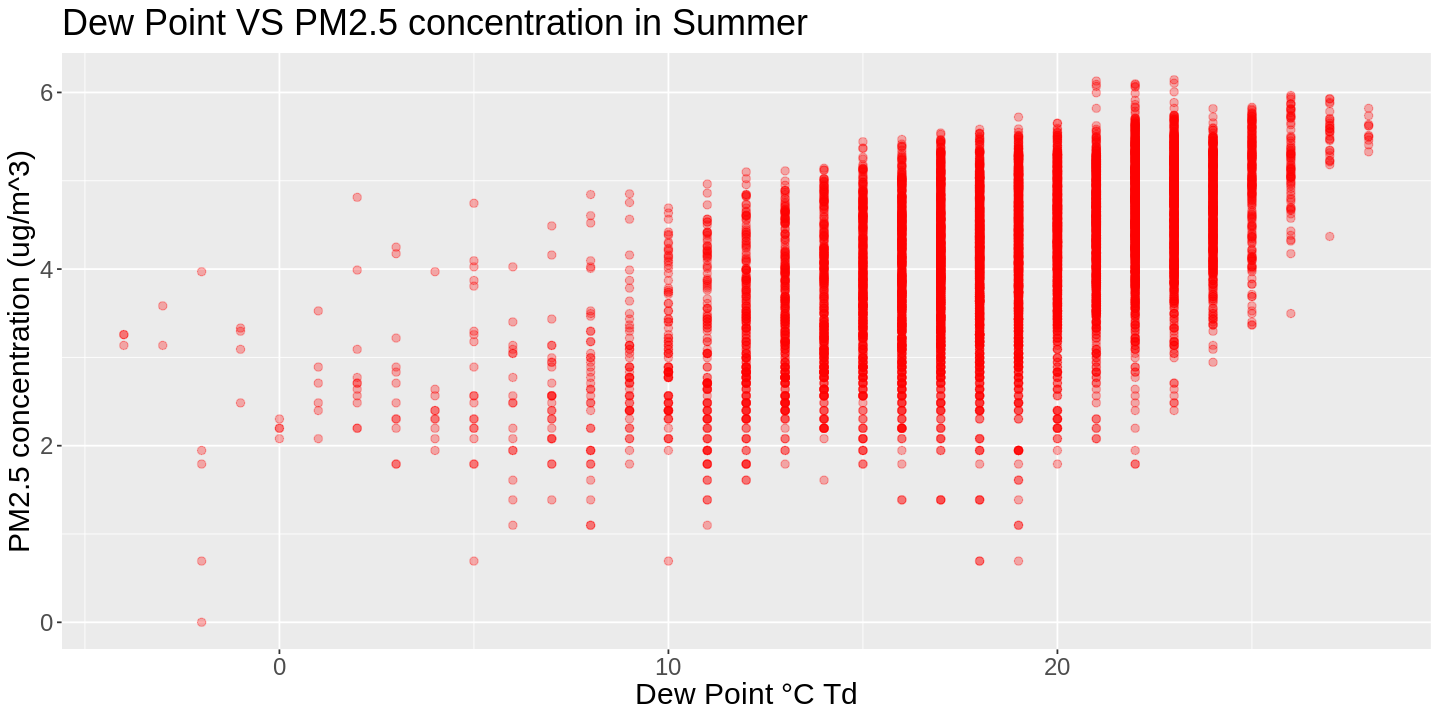

In [7]:
options(repr.plot.width = 12, repr.plot.height = 6)
idx_s <- pm2.5_s$season=="Fall"
fall<- pm2.5_s[idx_s,]
dewp_season_fall <- ggplot(fall, aes(x = DEWP, y = pm2.5)) +
  geom_point(
    color = 'orange',
    size = 2,
    alpha = 0.3
  )+
  xlab("Dew Point °C Td") +
  ylab("PM2.5 concentration (ug/m^3)") +
  ggtitle("Dew Point VS PM2.5 concentration in Fall")+
  theme(text = element_text(size = 18))


options(repr.plot.width = 12, repr.plot.height = 6)
idx_s1 <- pm2.5_s$season=="Winter"
winter<- pm2.5_s[idx_s1,]
dewp_season_winter <- ggplot(winter, aes(x = DEWP, y = pm2.5)) +
  geom_point(
    color = 'dodgerblue',
    size = 2,
    alpha = 0.3
  )+
  xlab("Dew Point °C Td") +
  ylab("PM2.5 concentration (ug/m^3)") +
  ggtitle("Dew Point VS PM2.5 concentration in Winter")+
  theme(text = element_text(size = 18))

options(repr.plot.width = 12, repr.plot.height = 6)
idx_s2 <- pm2.5_s$season=="Spring"
spring<- pm2.5_s[idx_s2,]
dewp_season_spring <- ggplot(spring, aes(x = DEWP, y = pm2.5)) +
  geom_point(
    color = 'chartreuse4',
    size = 2,
    alpha = 0.3
  )+
  xlab("Dew Point °C Td") +
  ylab("PM2.5 concentration (ug/m^3)") +
  ggtitle("Dew Point VS PM2.5 concentration in Spring")+
  theme(text = element_text(size = 18))



options(repr.plot.width = 12, repr.plot.height = 6)
idx_s3 <- pm2.5_s$season=="Summer"
summer<- pm2.5_s[idx_s3,]
dewp_season_summer <- ggplot(summer, aes(x = DEWP, y = pm2.5)) +
  geom_point(
    color = 'red',
    size = 2,
    alpha = 0.3
  )+
  xlab("Dew Point °C Td") +
  ylab("PM2.5 concentration (ug/m^3)") +
  ggtitle("Dew Point VS PM2.5 concentration in Summer")+
  theme(text = element_text(size = 18))

dewp_season_fall
dewp_season_winter
dewp_season_spring
dewp_season_summer

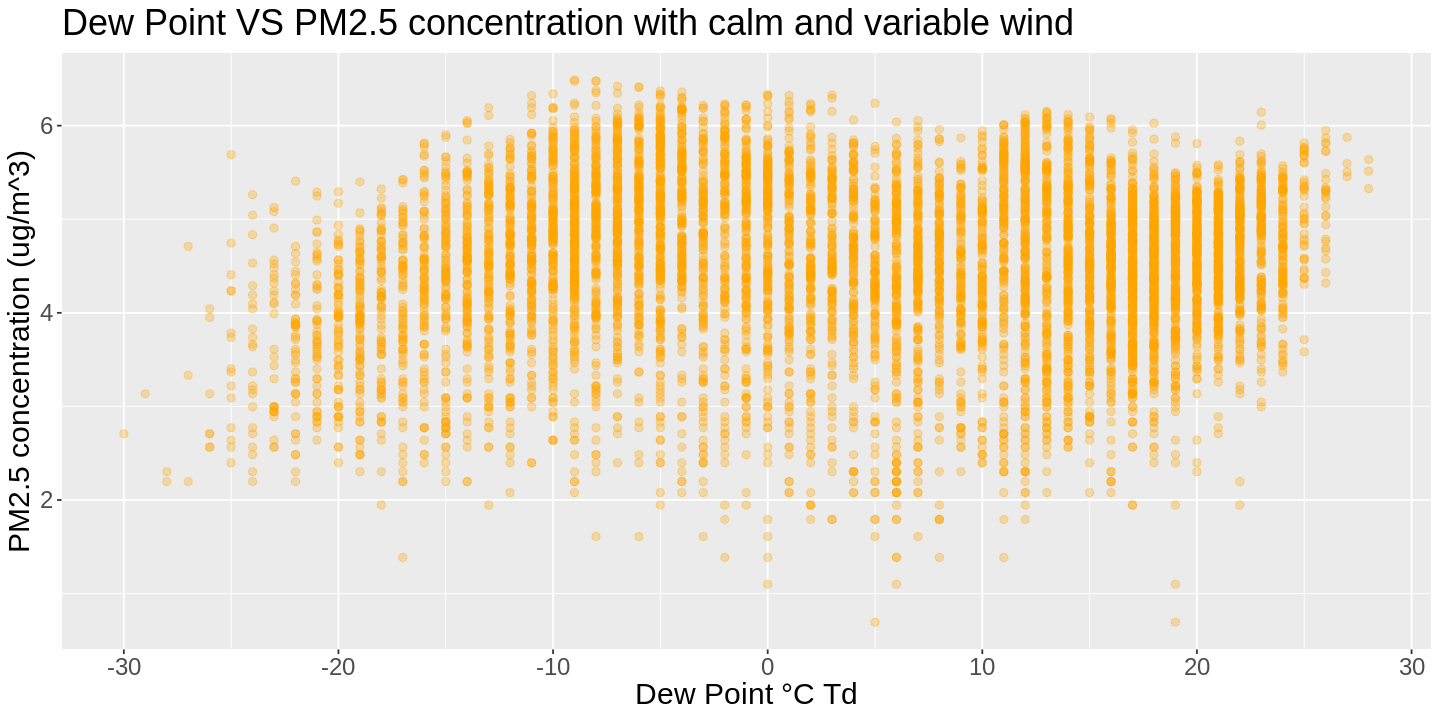

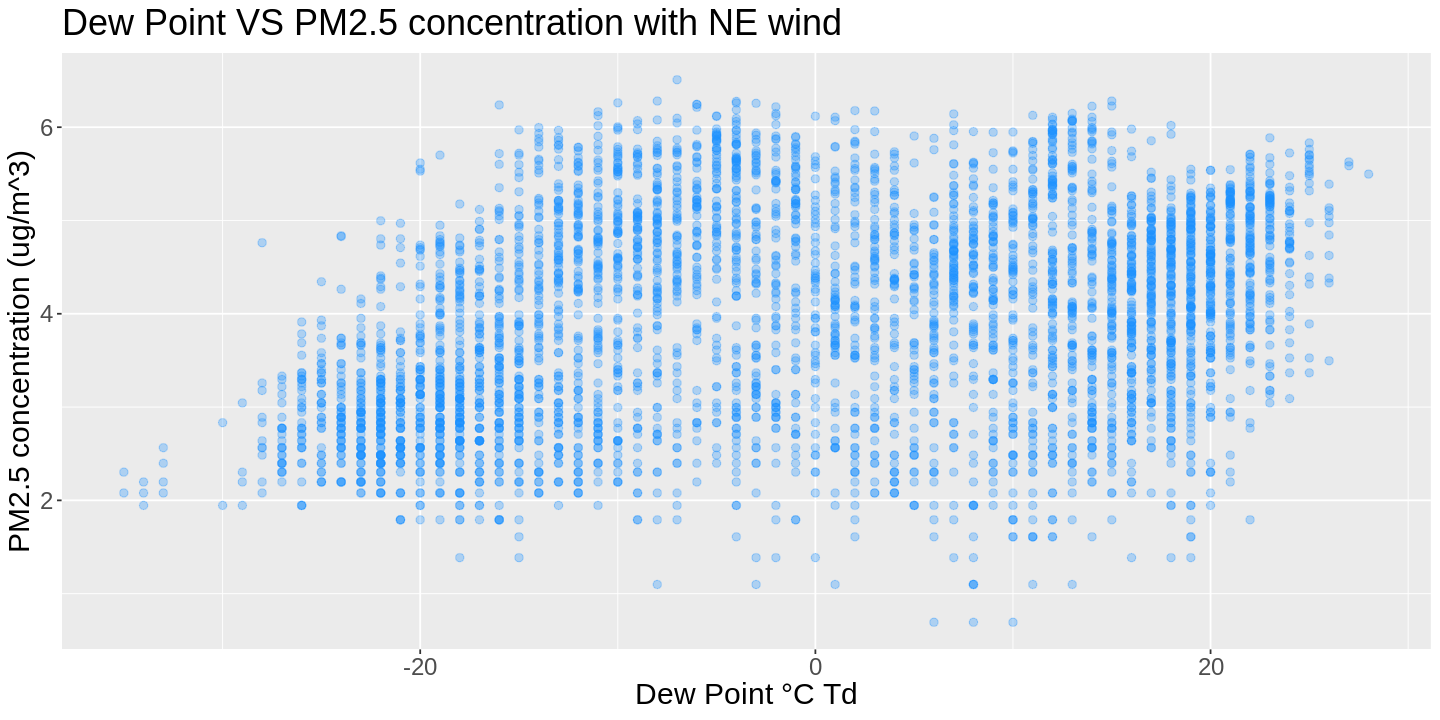

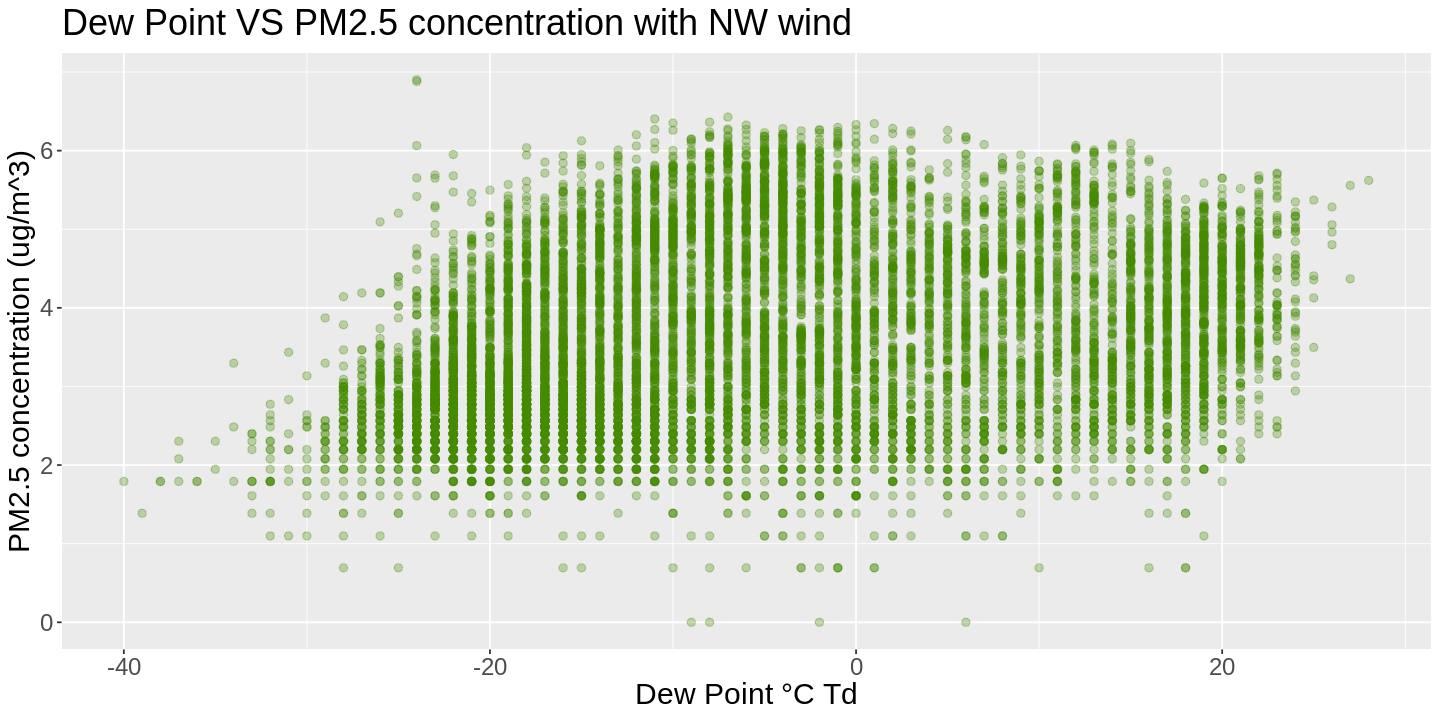

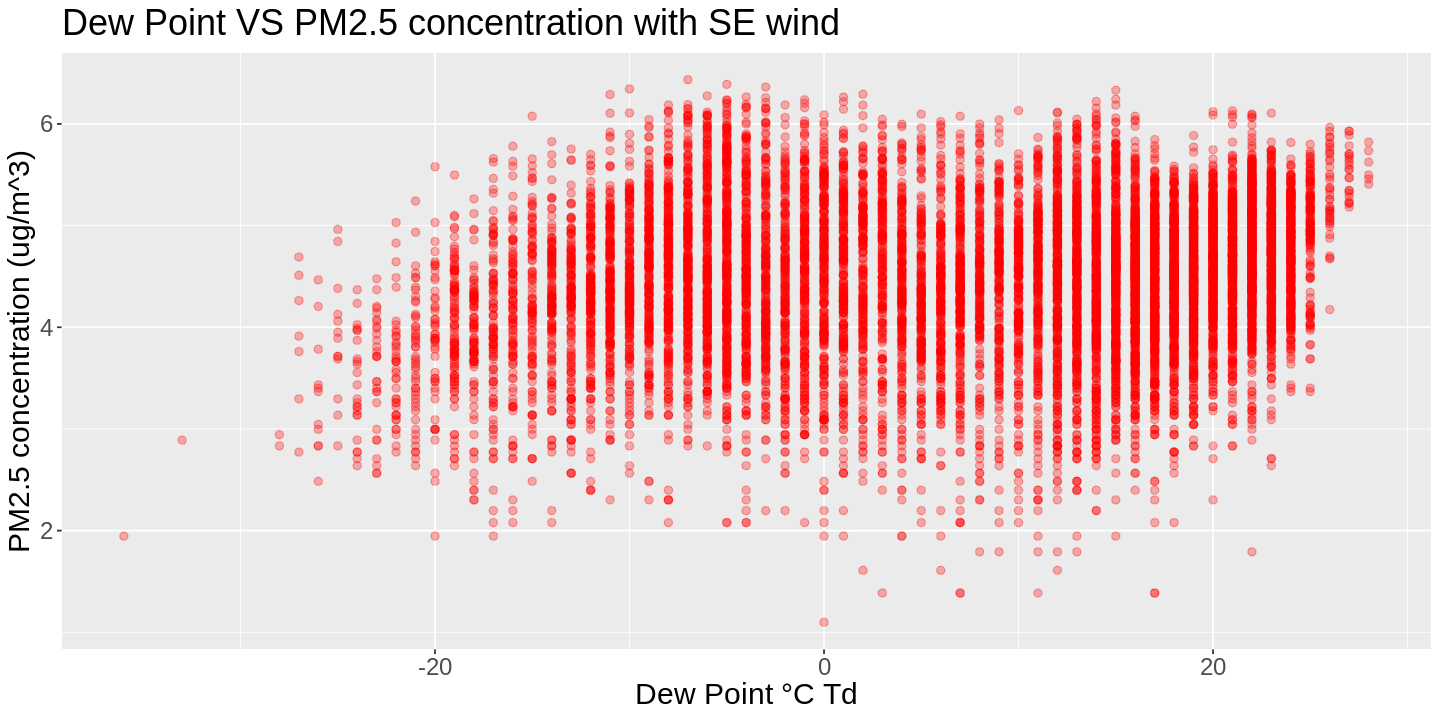

In [8]:
options(repr.plot.width = 12, repr.plot.height = 6)
idx_cv <- pm2.5_s$cbwd=="cv"
cv<- pm2.5_s[idx_cv,]
cv_1 <- ggplot(cv, aes(x = DEWP, y = pm2.5)) +
  geom_point(
    color = 'orange',
    size = 2,
    alpha = 0.3
  )+
  xlab("Dew Point °C Td") +
  ylab("PM2.5 concentration (ug/m^3)") +
  ggtitle("Dew Point VS PM2.5 concentration with calm and variable wind")+
  theme(text = element_text(size = 18))


options(repr.plot.width = 12, repr.plot.height = 6)
idx_ne <- pm2.5_s$cbwd=="NE"
ne<- pm2.5_s[idx_ne,]
ne_1 <- ggplot(ne, aes(x = DEWP, y = pm2.5)) +
  geom_point(
    color = 'dodgerblue',
    size = 2,
    alpha = 0.3
  )+
  xlab("Dew Point °C Td") +
  ylab("PM2.5 concentration (ug/m^3)") +
  ggtitle("Dew Point VS PM2.5 concentration with NE wind")+
  theme(text = element_text(size = 18))

options(repr.plot.width = 12, repr.plot.height = 6)
idx_nw <- pm2.5_s$cbwd=="NW"
nw<- pm2.5_s[idx_nw,]
nw_1 <- ggplot(nw, aes(x = DEWP, y = pm2.5)) +
  geom_point(
    color = 'chartreuse4',
    size = 2,
    alpha = 0.3
  )+
  xlab("Dew Point °C Td") +
  ylab("PM2.5 concentration (ug/m^3)") +
  ggtitle("Dew Point VS PM2.5 concentration with NW wind")+
  theme(text = element_text(size = 18))



options(repr.plot.width = 12, repr.plot.height = 6)
idx_se <- pm2.5_s$cbwd=="SE"
se<- pm2.5_s[idx_se,]
se_1 <- ggplot(se, aes(x = DEWP, y = pm2.5)) +
  geom_point(
    color = 'red',
    size = 2,
    alpha = 0.3
  )+
  xlab("Dew Point °C Td") +
  ylab("PM2.5 concentration (ug/m^3)") +
  ggtitle("Dew Point VS PM2.5 concentration with SE wind")+
  theme(text = element_text(size = 18))

cv_1
ne_1
nw_1
se_1

Warning message:
“`fun.y` is deprecated. Use `fun` instead.”


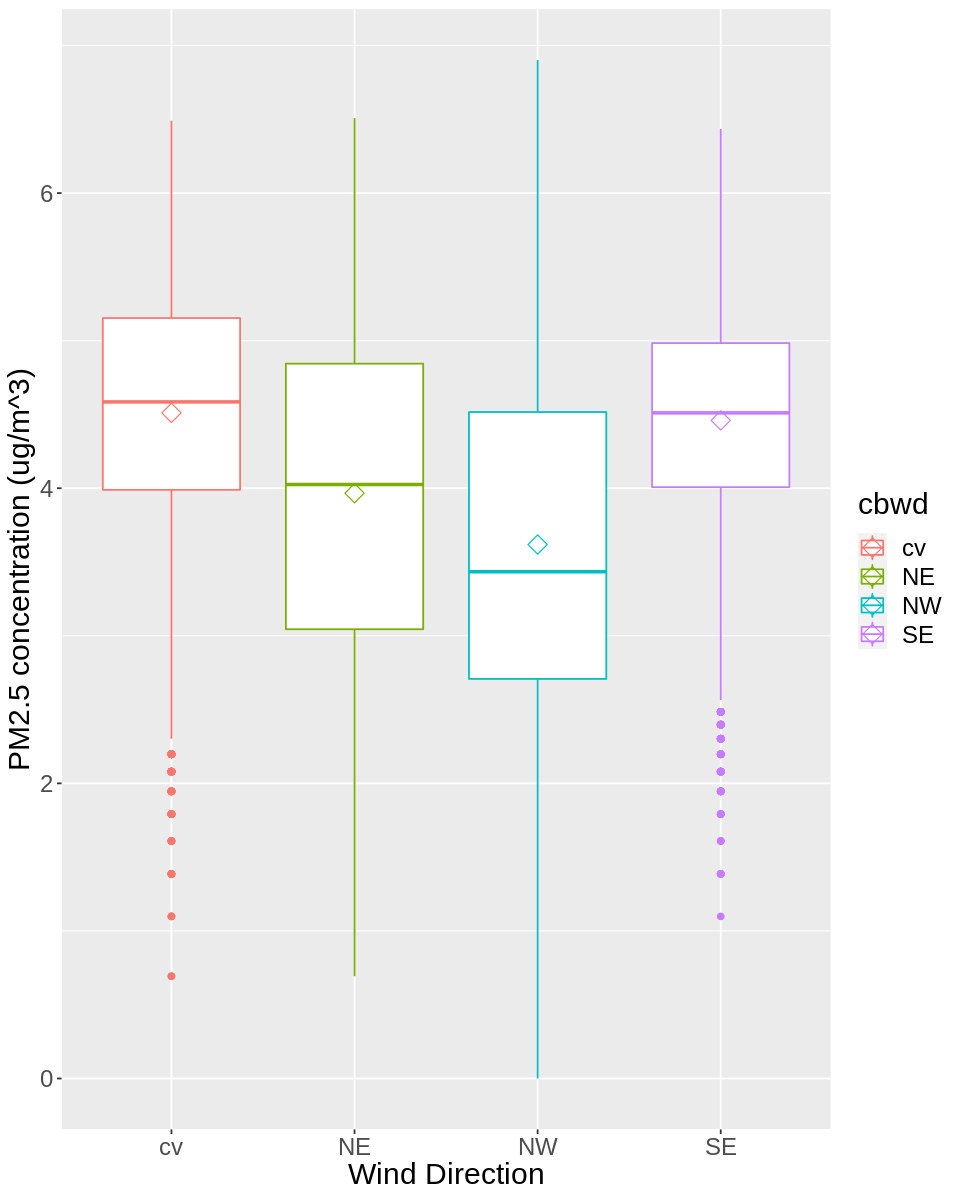

In [9]:
options(repr.plot.width = 8, repr.plot.height = 10)
wind_direction<-ggplot(pm2.5_s, aes(x=cbwd, y=pm2.5, color=cbwd)) +
  geom_boxplot() +
  xlab("Wind Direction") +
  ylab("PM2.5 concentration (ug/m^3)") +
  theme(text = element_text(size = 18))+
  # Box plot with mean points
  stat_summary(fun.y=mean, geom="point", shape=23, size=4)

wind_direction

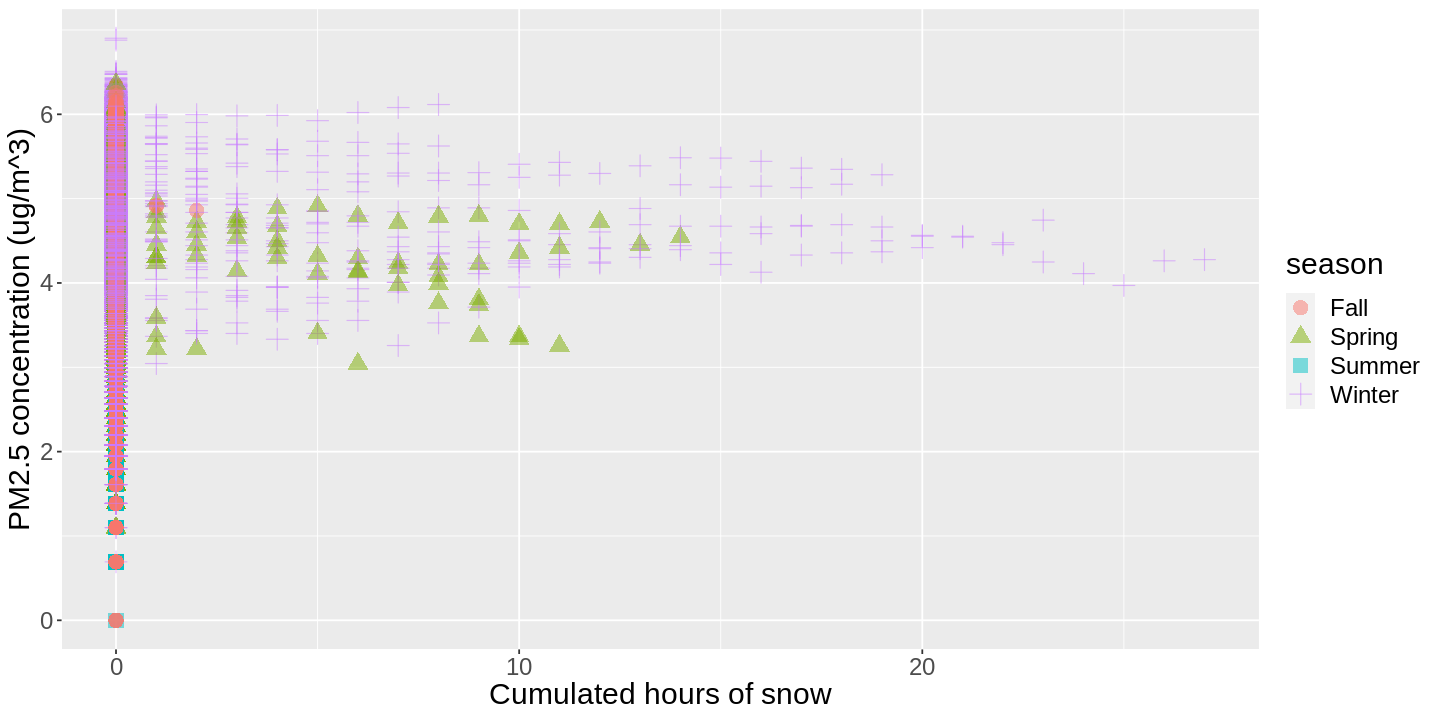

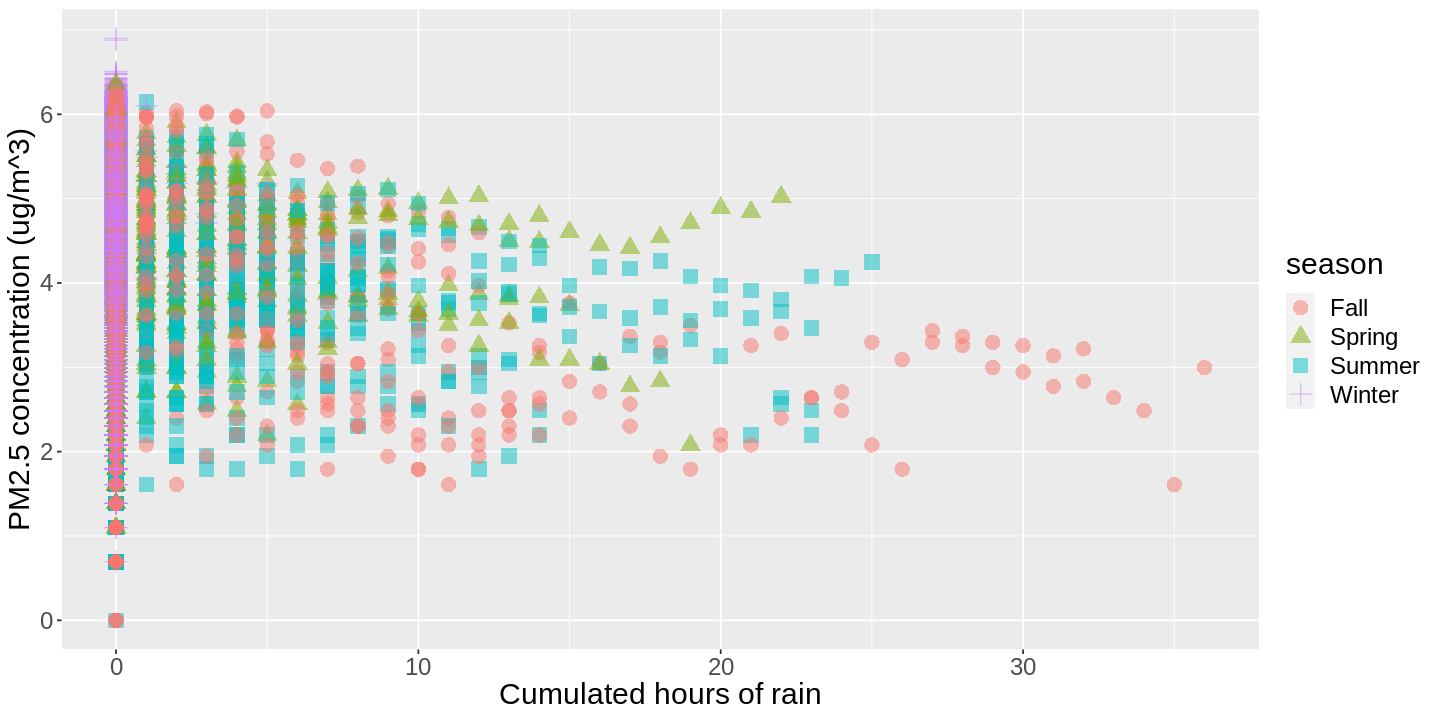

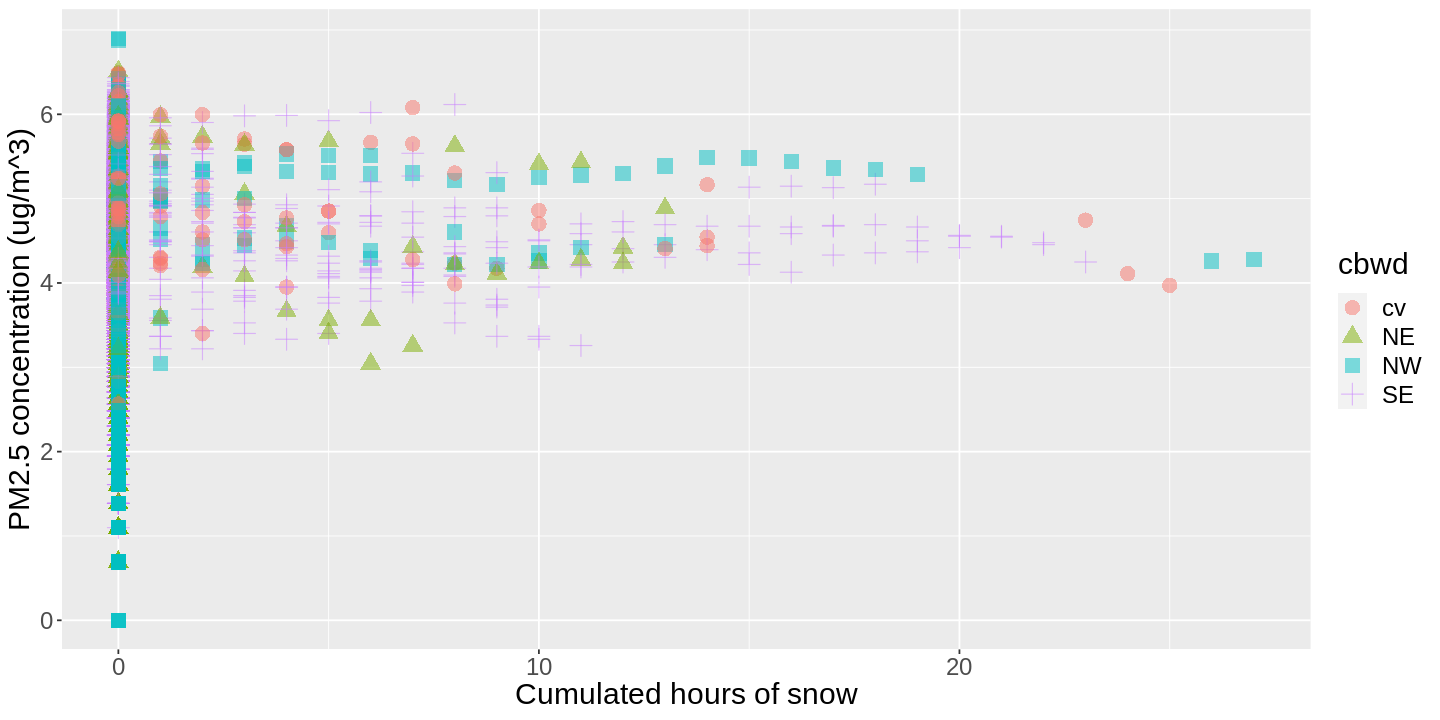

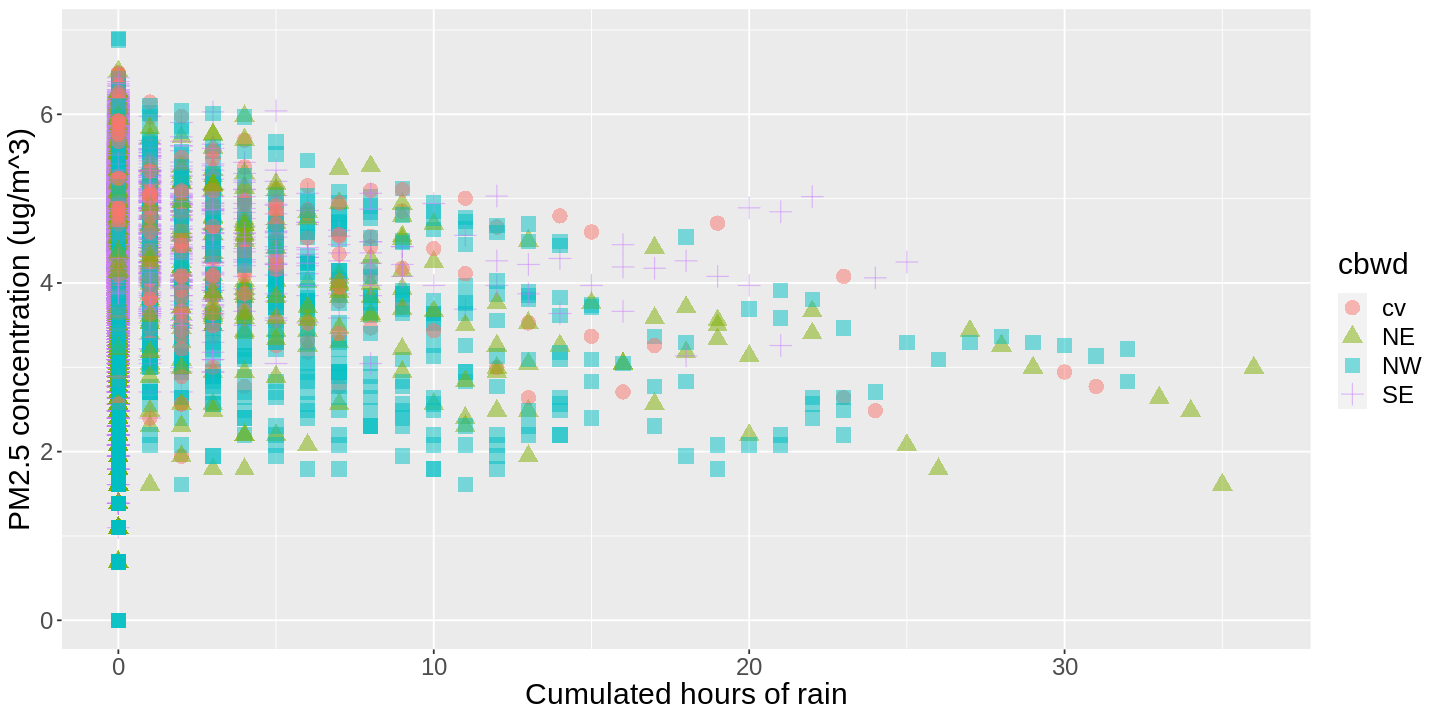

In [10]:
# not important variables
options(repr.plot.width = 12, repr.plot.height = 6)
# season
snows <- ggplot(pm2.5_s, aes(x =Is , y = pm2.5)) +
  geom_point(
    aes(color = season, shape = season),
    size = 4,
    alpha = 0.5
  )+
  xlab("Cumulated hours of snow") +
  ylab("PM2.5 concentration (ug/m^3)") +
  theme(text = element_text(size = 18))

rains <- ggplot(pm2.5_s, aes(x =Ir , y = pm2.5)) +
  geom_point(
    aes(color = season, shape = season),
    size = 4,
    alpha = 0.5
  )+
  xlab("Cumulated hours of rain") +
  ylab("PM2.5 concentration (ug/m^3)") +
  theme(text = element_text(size = 18))

# wind direction
snow <- ggplot(pm2.5_s, aes(x =Is , y = pm2.5)) +
  geom_point(
    aes(color = cbwd, shape = cbwd),
    size = 4,
    alpha = 0.5
  )+
  xlab("Cumulated hours of snow") +
  ylab("PM2.5 concentration (ug/m^3)") +
  theme(text = element_text(size = 18))

rain <- ggplot(pm2.5_s, aes(x =Ir , y = pm2.5)) +
  geom_point(
    aes(color = cbwd, shape = cbwd),
    size = 4,
    alpha = 0.5
  )+
  xlab("Cumulated hours of rain") +
  ylab("PM2.5 concentration (ug/m^3)") +
  theme(text = element_text(size = 18))
snows
rains
snow
rain

In [11]:
# with one categorical variable : season
season_c<-lm(pm2.5~DEWP+TEMP+PRES+season, data=pm2.5_s)
season_s <- summary(season_c)
season_s


Call:
lm(formula = pm2.5 ~ DEWP + TEMP + PRES + season, data = pm2.5_s)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.5156 -0.5315  0.0555  0.5959  3.0941 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)  22.9366309  0.8517928   26.93   <2e-16 ***
DEWP          0.0810834  0.0006321  128.28   <2e-16 ***
TEMP         -0.0583158  0.0007912  -73.70   <2e-16 ***
PRES         -0.0180576  0.0008308  -21.73   <2e-16 ***
seasonSpring  0.3643583  0.0133503   27.29   <2e-16 ***
seasonSummer -0.5827387  0.0158345  -36.80   <2e-16 ***
seasonWinter  0.7527364  0.0164445   45.77   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8256 on 37695 degrees of freedom
Multiple R-squared:  0.3574,	Adjusted R-squared:  0.3573 
F-statistic:  3494 on 6 and 37695 DF,  p-value: < 2.2e-16


In [12]:
#The contrasts() function returns the coding that R have used to create the dummy variables
contrasts(pm2.5_s$season)

Spring Summer Winter
Fall   0      0      0     
Spring 1      0      0     
Summer 0      1      0     
Winter 0      0      1

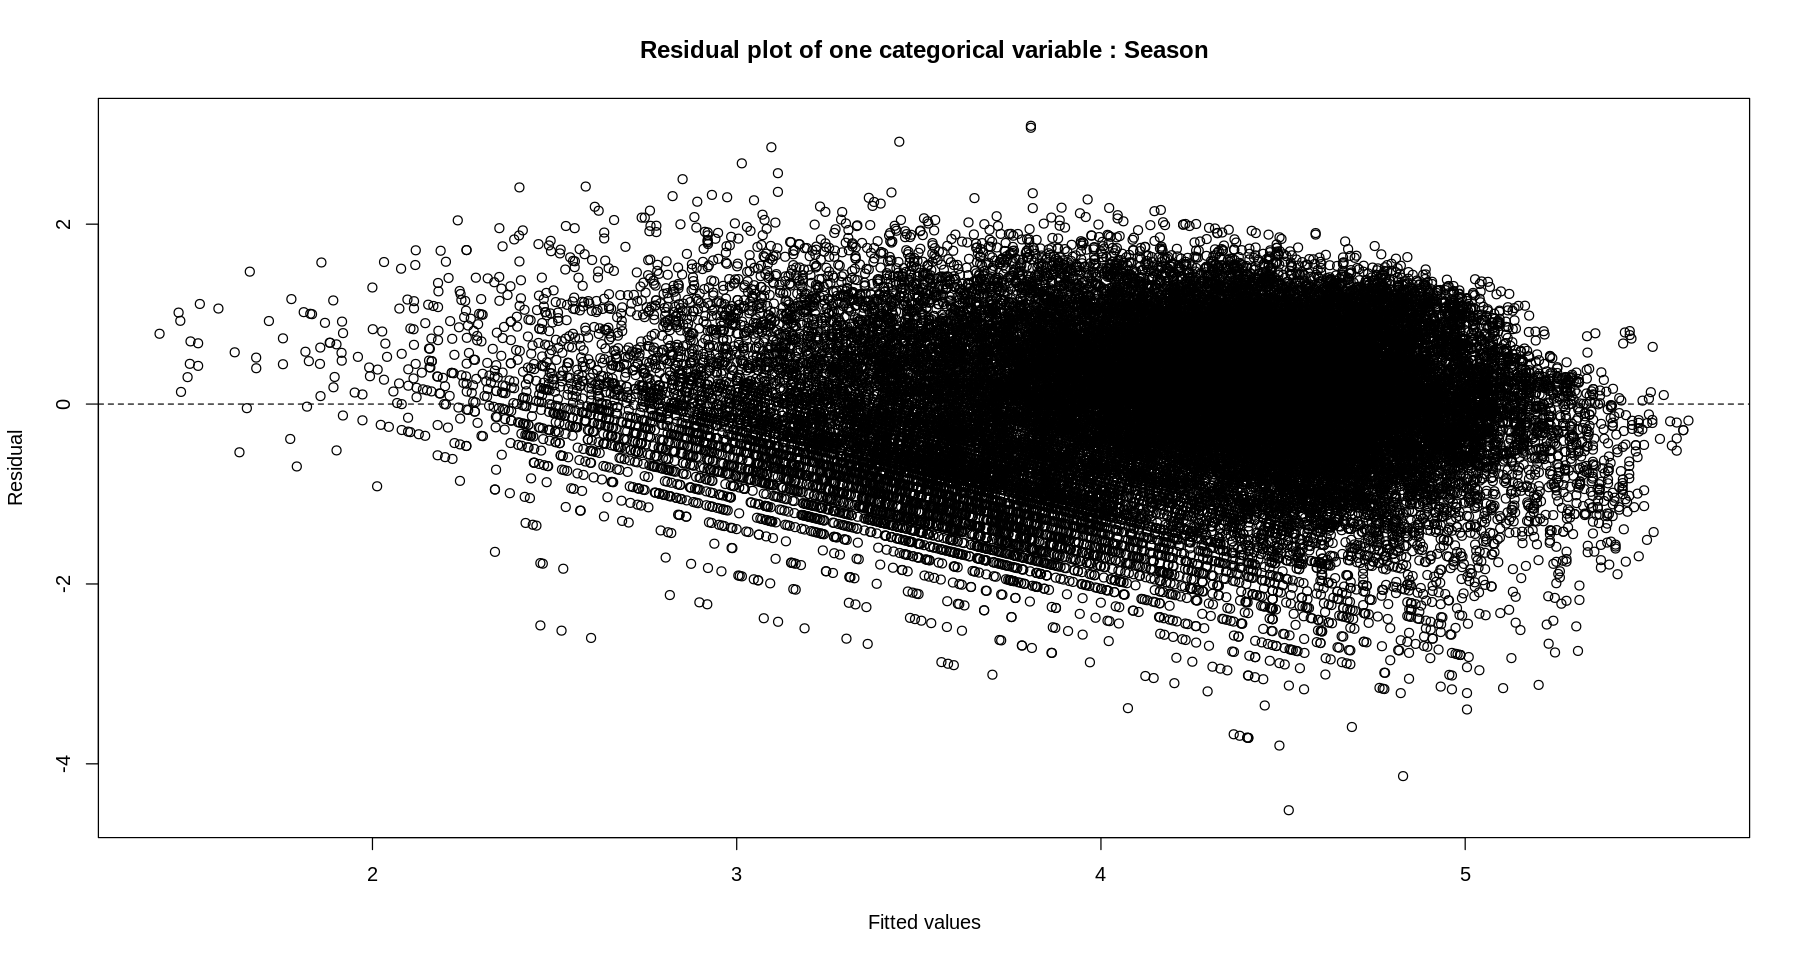

In [13]:
#residual plot one categorical variable : season
options(repr.plot.width = 15, repr.plot.height = 8)
plot(x = fitted(season_c), 
     y = residuals(season_c),
     xlab = "Fitted values",
     ylab = "Residual",
     main = "Residual plot of one categorical variable : Season")
abline(h = 0, lty = 2)

In [14]:
# with one categorical variable : wind direction
wdirection_c<-lm(pm2.5~DEWP+TEMP+PRES+cbwd, data=pm2.5_s)
wdirection_s <- summary(wdirection_c)
wdirection_s


Call:
lm(formula = pm2.5 ~ DEWP + TEMP + PRES + cbwd, data = pm2.5_s)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.1716 -0.5406  0.0190  0.5661  3.1716 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) 27.7459420  0.7718155   35.95   <2e-16 ***
DEWP         0.0547163  0.0005515   99.22   <2e-16 ***
TEMP        -0.0754079  0.0007156 -105.38   <2e-16 ***
PRES        -0.0221907  0.0007545  -29.41   <2e-16 ***
cbwdNE      -0.4309867  0.0153406  -28.09   <2e-16 ***
cbwdNW      -0.6360639  0.0120080  -52.97   <2e-16 ***
cbwdSE       0.1223072  0.0116665   10.48   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8097 on 37695 degrees of freedom
Multiple R-squared:  0.3819,	Adjusted R-squared:  0.3818 
F-statistic:  3882 on 6 and 37695 DF,  p-value: < 2.2e-16


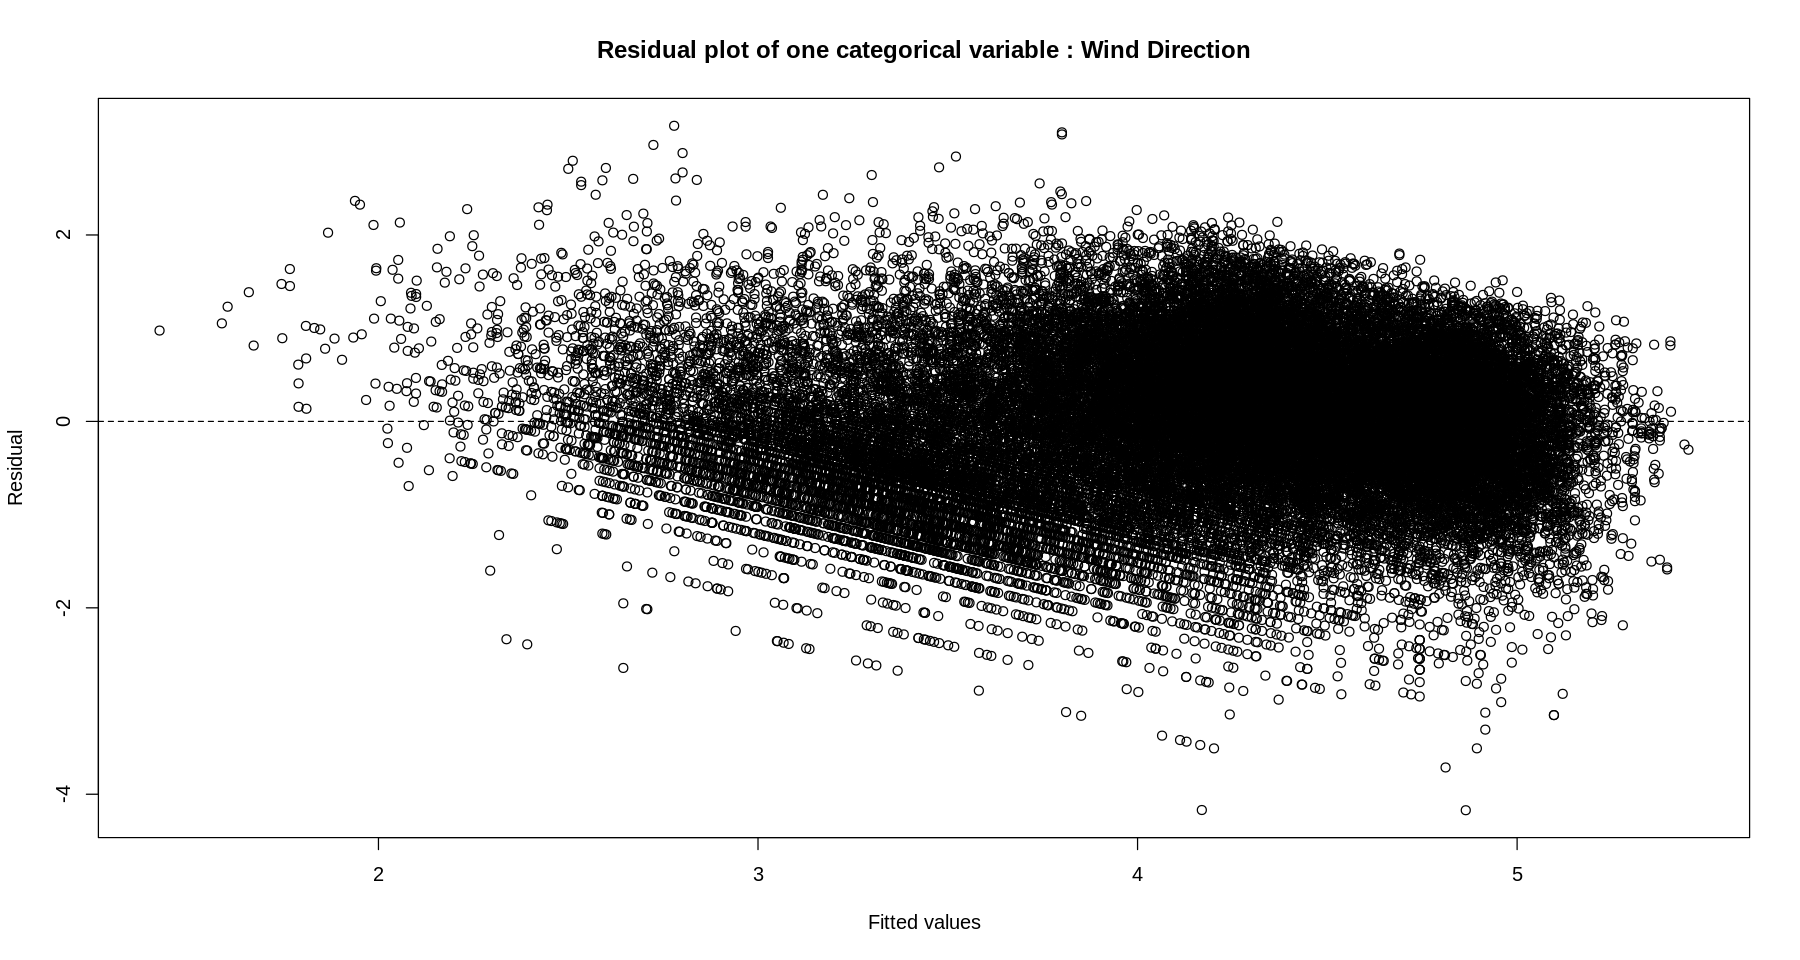

In [15]:
#residual plot one categorical variable : wind direction
options(repr.plot.width = 15, repr.plot.height = 8)
plot(x = fitted(wdirection_c), 
     y = residuals(wdirection_c),
     xlab = "Fitted values",
     ylab = "Residual",
     main = "Residual plot of one categorical variable : Wind Direction")
abline(h = 0, lty = 2)

In [16]:
# with two categorical variable : wind direction, season
two_c <-lm(pm2.5~DEWP+TEMP+PRES+cbwd+season, data=pm2.5_s)
two <- summary(two_c)
two


Call:
lm(formula = pm2.5 ~ DEWP + TEMP + PRES + cbwd + season, data = pm2.5_s)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.1733 -0.5164  0.0205  0.5511  3.2435 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)  27.3729571  0.8091356  33.830  < 2e-16 ***
DEWP          0.0703876  0.0006210 113.343  < 2e-16 ***
TEMP         -0.0629790  0.0007597 -82.902  < 2e-16 ***
PRES         -0.0220821  0.0007891 -27.982  < 2e-16 ***
cbwdNE       -0.4009779  0.0147961 -27.100  < 2e-16 ***
cbwdNW       -0.5756148  0.0116228 -49.525  < 2e-16 ***
cbwdSE        0.0880978  0.0113285   7.777 7.64e-15 ***
seasonSpring  0.2339358  0.0128273  18.237  < 2e-16 ***
seasonSummer -0.5525949  0.0149857 -36.875  < 2e-16 ***
seasonWinter  0.5832098  0.0157924  36.930  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.7799 on 37692 degrees of freedom
Multiple R-squared:  0.4266,	Adjusted R-squared:  0.4265 
F-statist

In [17]:
contrasts(pm2.5_s$season)
contrasts(pm2.5_s$cbwd)

Spring Summer Winter
Fall   0      0      0     
Spring 1      0      0     
Summer 0      1      0     
Winter 0      0      1

NE NW SE
cv 0  0  0 
NE 1  0  0 
NW 0  1  0 
SE 0  0  1

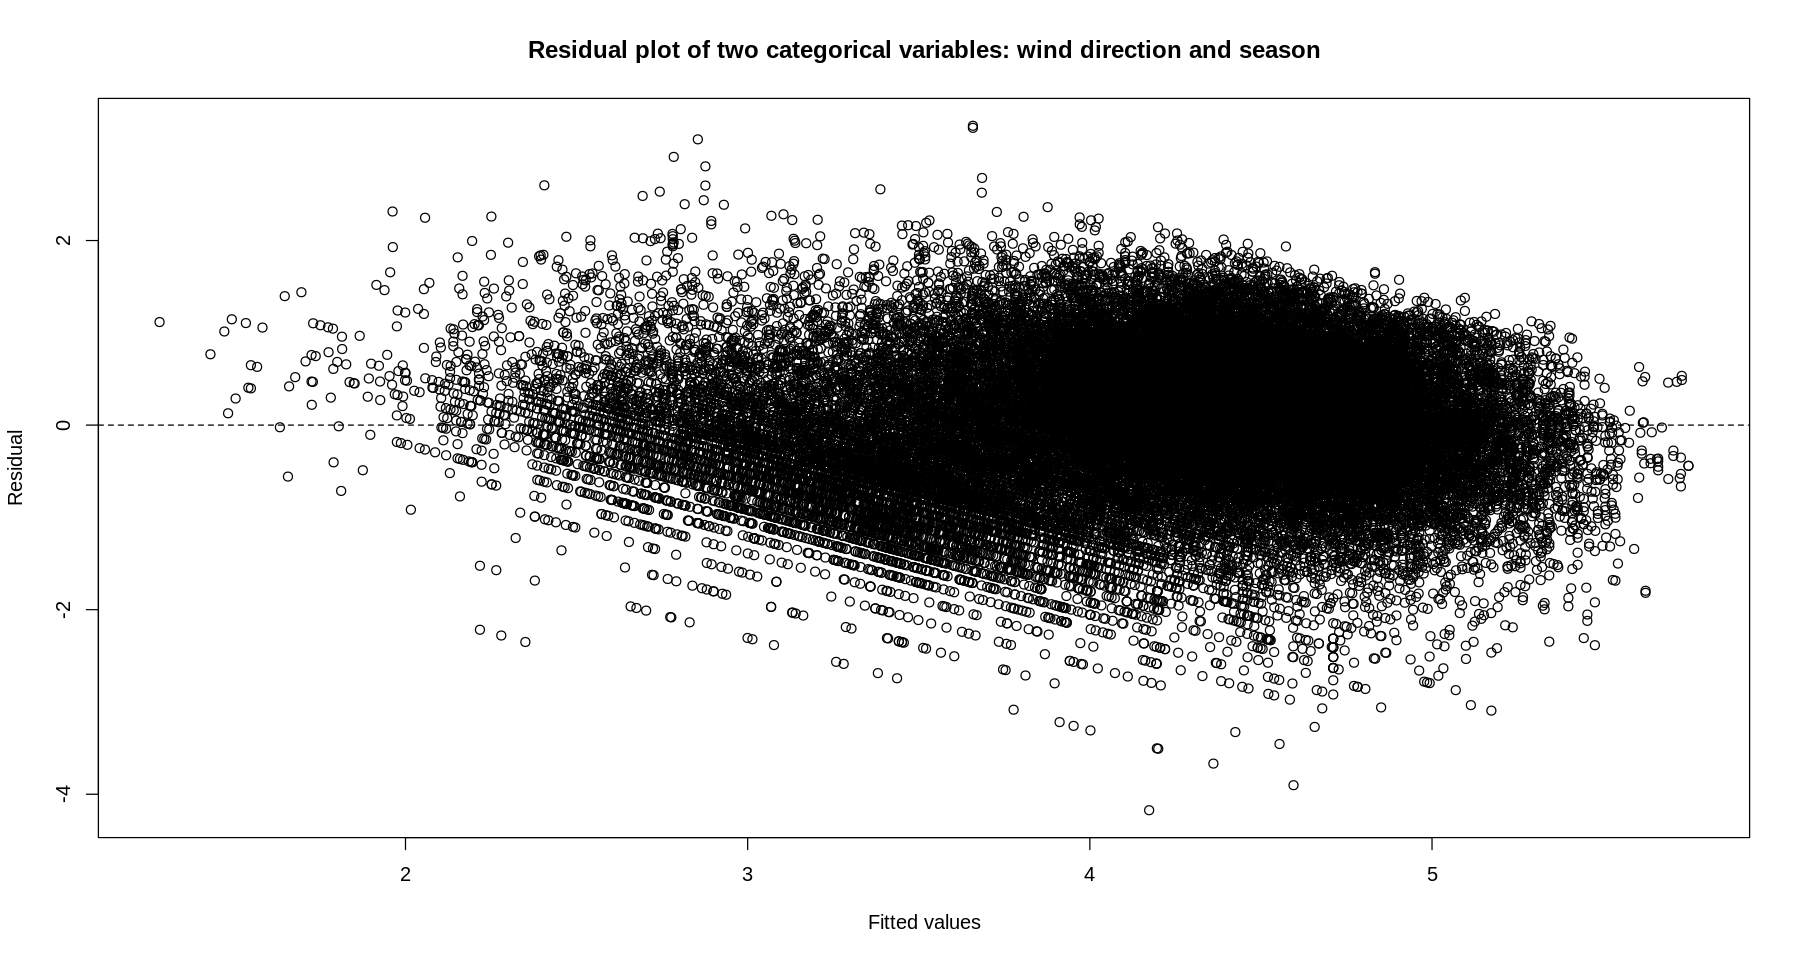

In [18]:
#residual plot v5
options(repr.plot.width = 15, repr.plot.height = 8)
plot(x = fitted(two_c), 
     y = residuals(two_c),
     xlab = "Fitted values",
     ylab = "Residual",
     main = "Residual plot of two categorical variables: wind direction and season")
abline(h = 0, lty = 2)

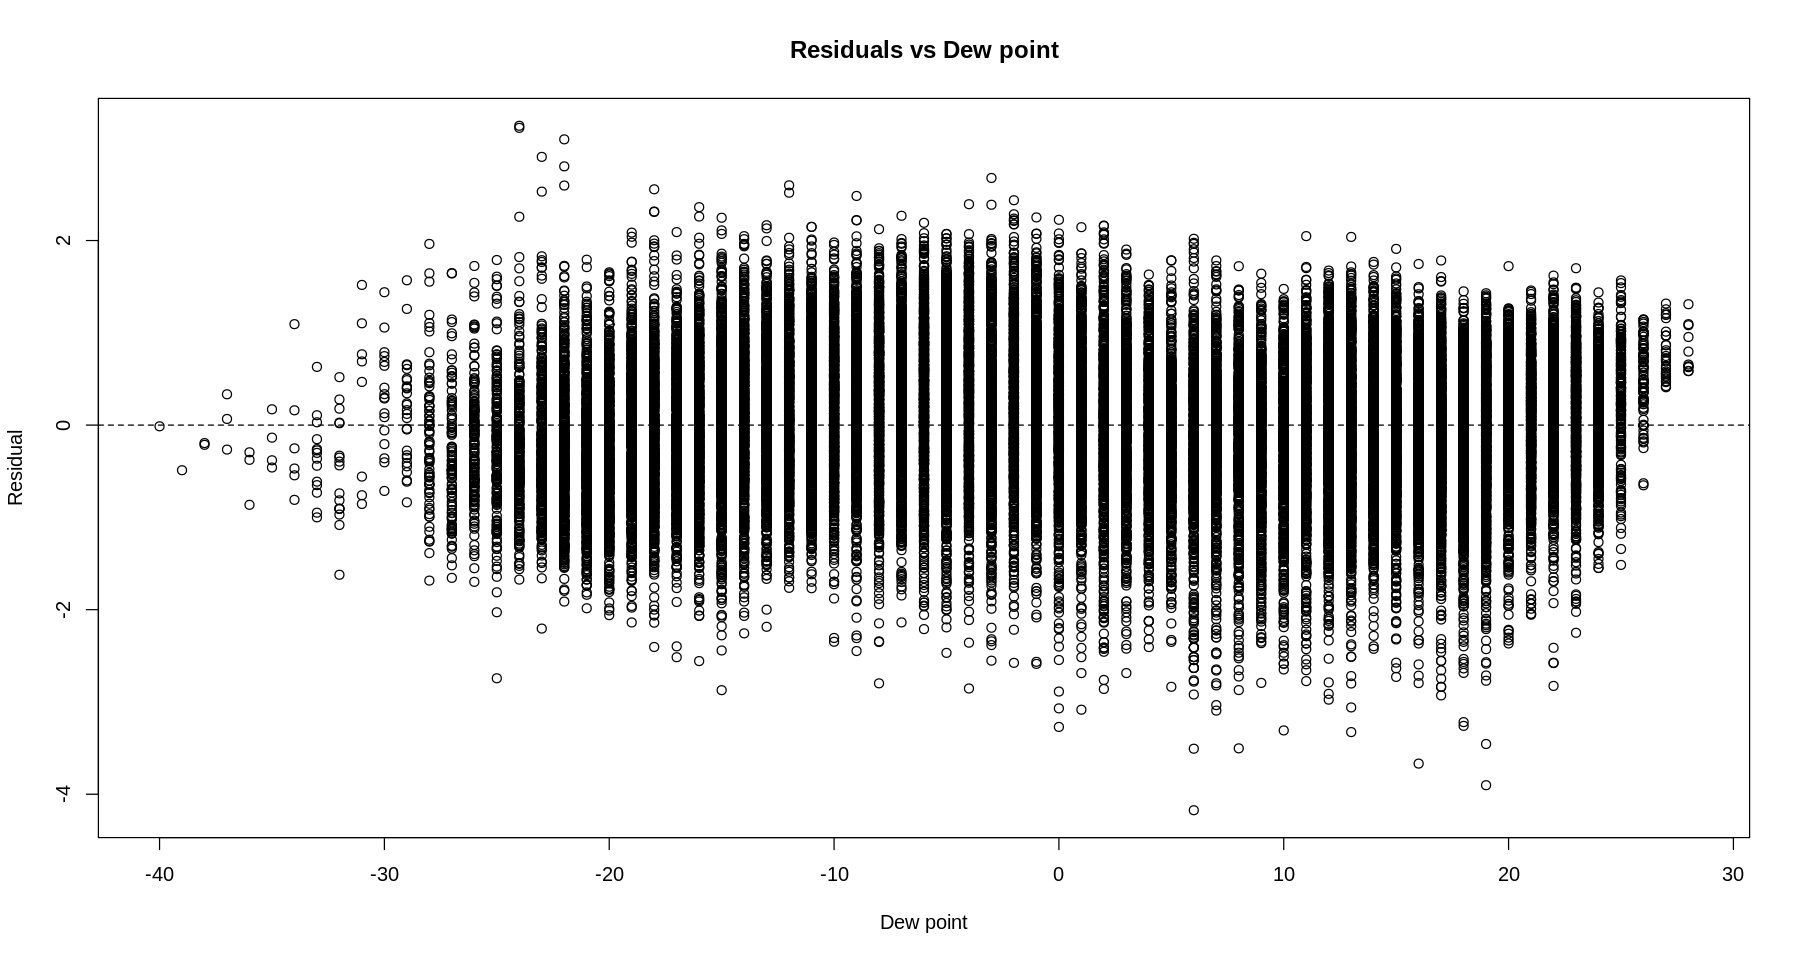

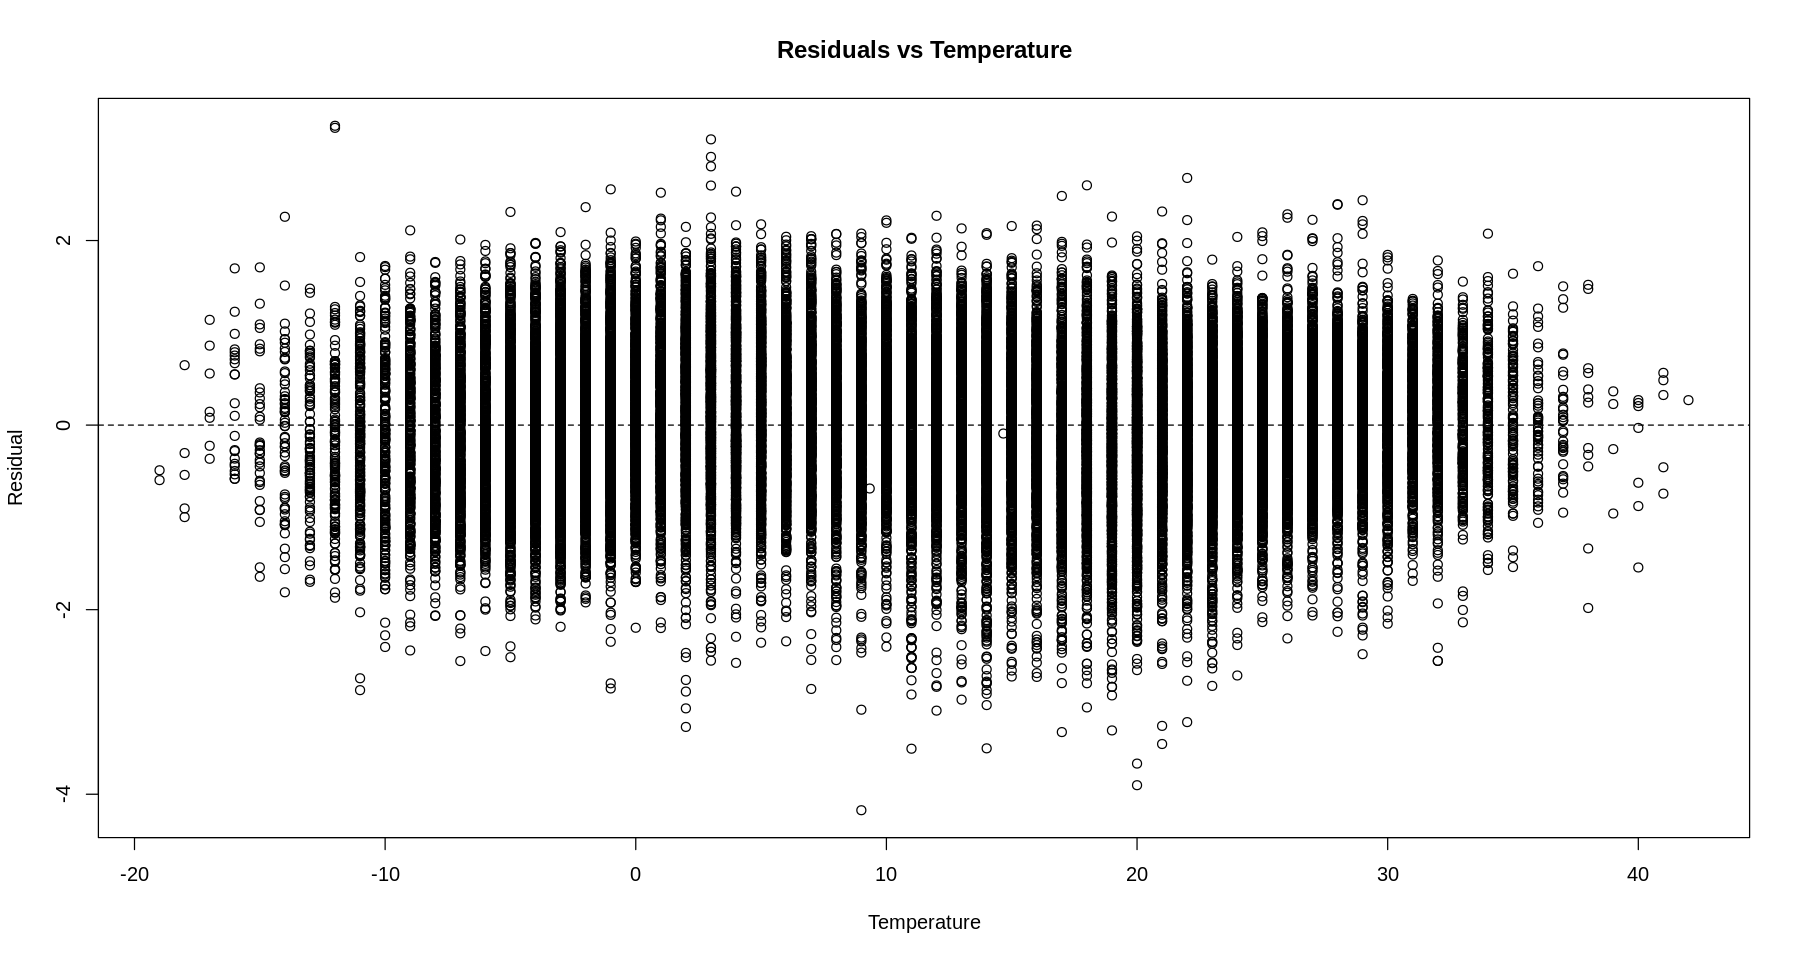

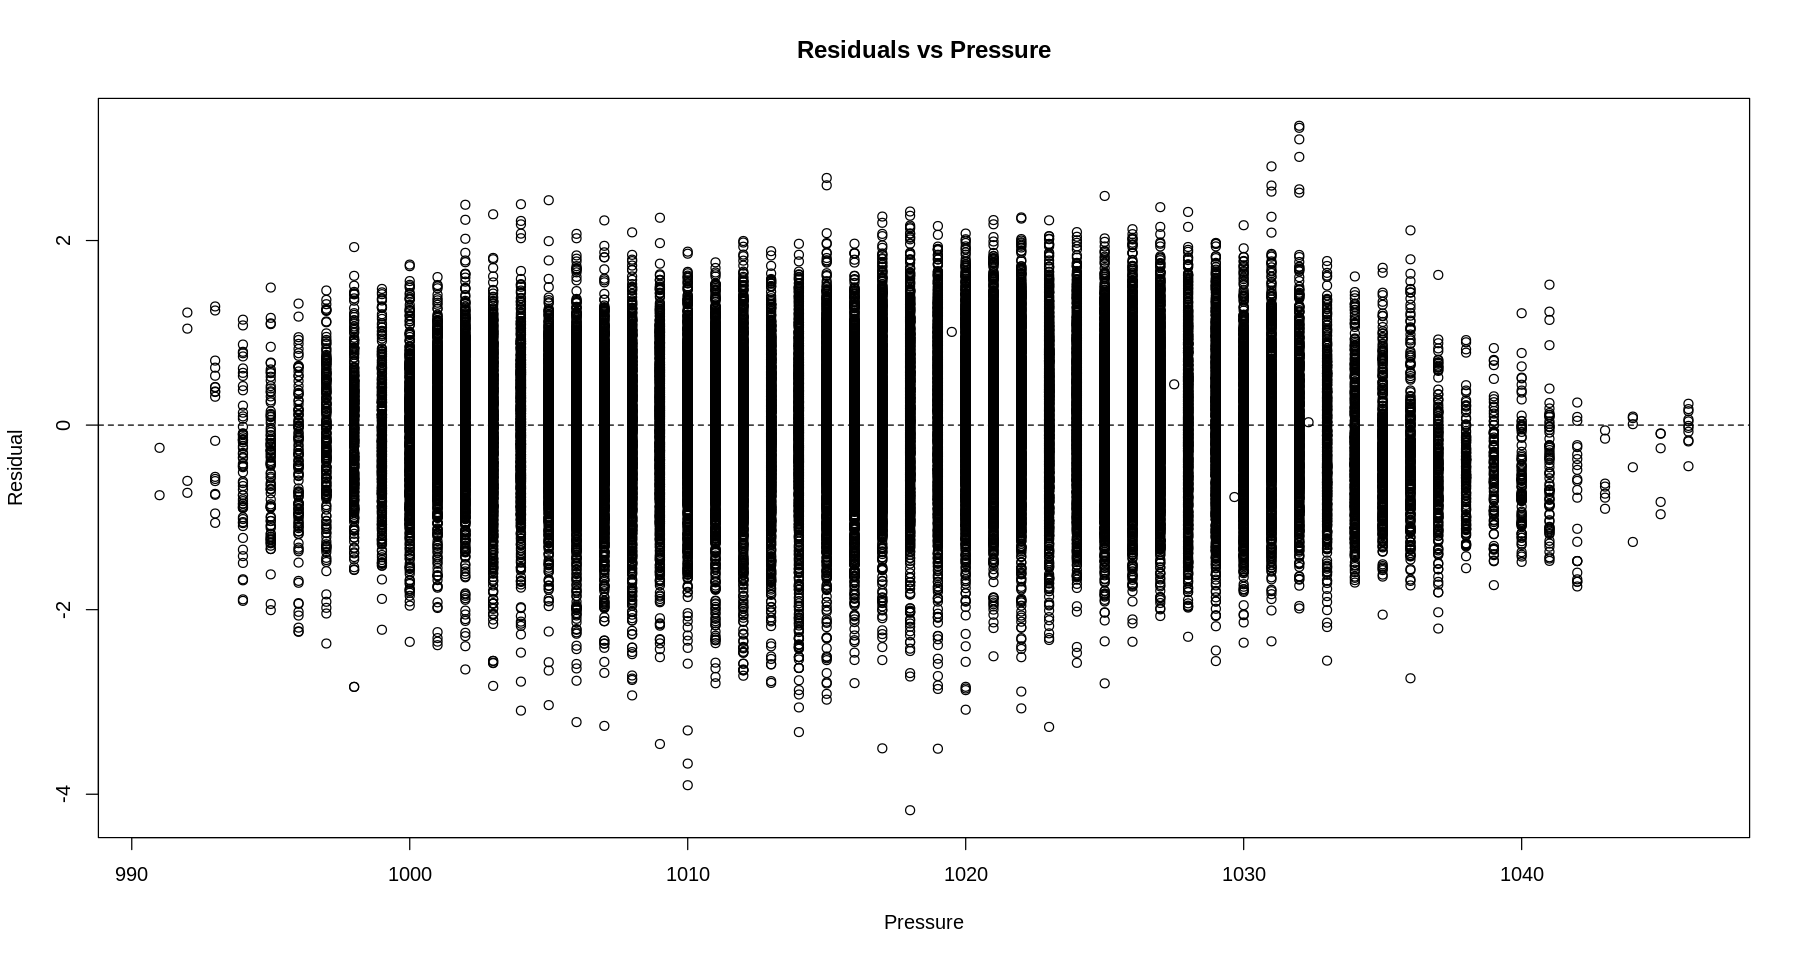

In [19]:
#covariates residual plots for the best model
options(repr.plot.width = 15, repr.plot.height = 8)
dew<-plot(x = pm2.5_s$DEWP, 
     y = residuals(two_c),
     xlab = "Dew point",
     ylab = "Residual",
     main = "Residuals vs Dew point")
abline(h = 0, lty = 2)

temp<-plot(x = pm2.5_s$TEMP, 
     y = residuals(two_c),
     xlab = "Temperature",
     ylab = "Residual",
     main = "Residuals vs Temperature")
abline(h = 0, lty = 2)

pres<-plot(x = pm2.5_s$PRES, 
     y = residuals(two_c),
     xlab = "Pressure",
     ylab = "Residual",
     main = "Residuals vs Pressure")
abline(h = 0, lty = 2)